In [1]:
import os
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("..")
from src.data.cifar10 import CIFAR10
from src.model.sqvae_image import CSQVAE
from src.utils import yaml_handler

In [3]:
# semi-supervised
v = 1

gpu_id = 9
dataset_name = "cifar10"
device = f"cuda:{gpu_id}"
checkpoint_dir = f"../models/{dataset_name}/{v}"
checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]
print(checkpoint_path)

# load config
config_path = f"{checkpoint_dir}/{dataset_name}.yaml"
config = yaml_handler.load(config_path)
latent_size = config.latent_size
latent_npts = latent_size[0] * latent_size[1]

# load model
model = CSQVAE(config)
model.configure_model()
model = model.to(device)
checkpoint = torch.load(checkpoint_path, weights_only=True, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

../models/cifar10/1/csqvae-mnist-d64-bs512.ckpt-last-epoch=17.ckpt


<All keys matched successfully>

In [4]:
dataset_root = "../data/"
dataset = CIFAR10(False, root=dataset_root)
dataloader = DataLoader(
    dataset,
    1000,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

Files already downloaded and verified


In [5]:
results = []
for x, labels in tqdm(iter(dataloader), total=len(dataloader), ncols=100):
    batch = (x.to(device), labels)
    results += model.predict_step(batch)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.53it/s]


In [6]:
def plot_imgs(imgs, nsamples=100, ncols=10):
    nrows = nsamples // ncols
    fig = plt.figure(figsize=(10, 10))
    axs = fig.subplots(nrows, ncols)
    axs = axs.ravel()
    for i, img in enumerate(imgs[:nsamples]):
        axs[i].imshow(img)
        axs[i].axis("off")

    plt.show()

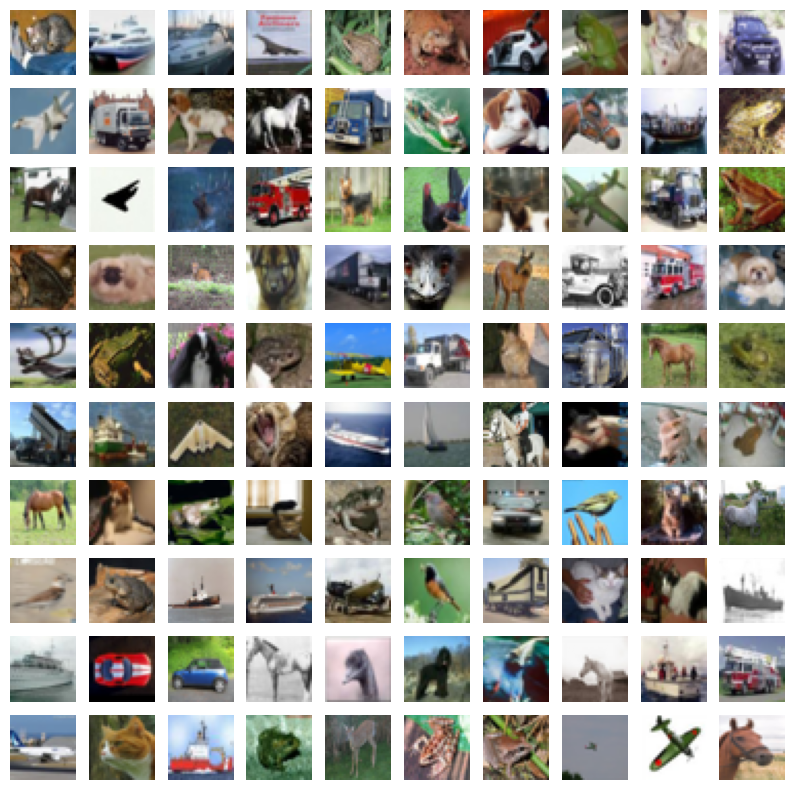

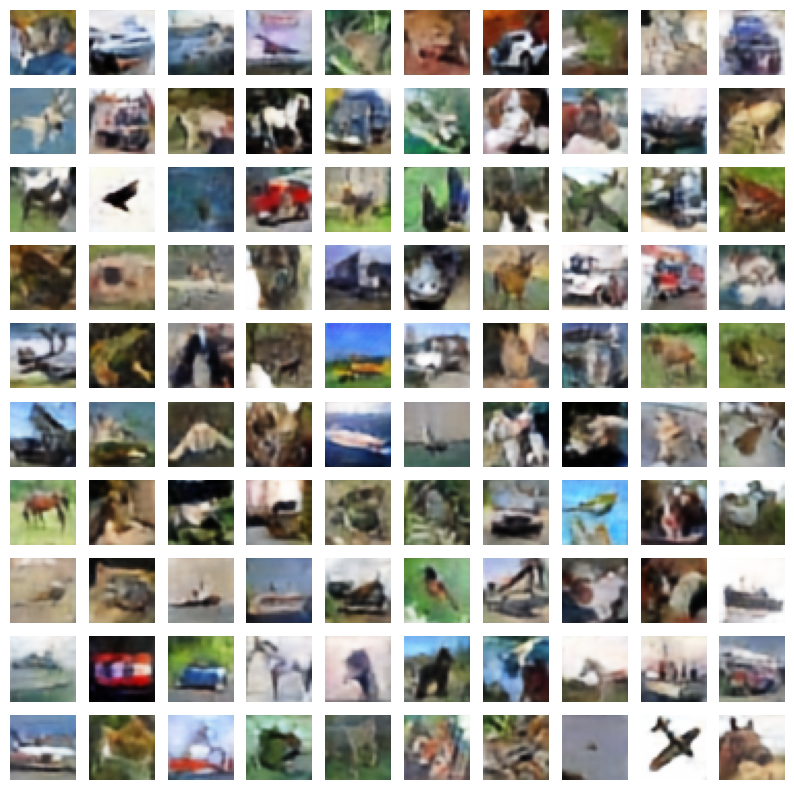

In [7]:
nsamples = 100
imgs_true = [r["x"] for r in results[:nsamples]]
plot_imgs(imgs_true, nsamples)
imgs_recon = [r["recon_x"] for r in results[:nsamples]]
plot_imgs(imgs_recon, nsamples)

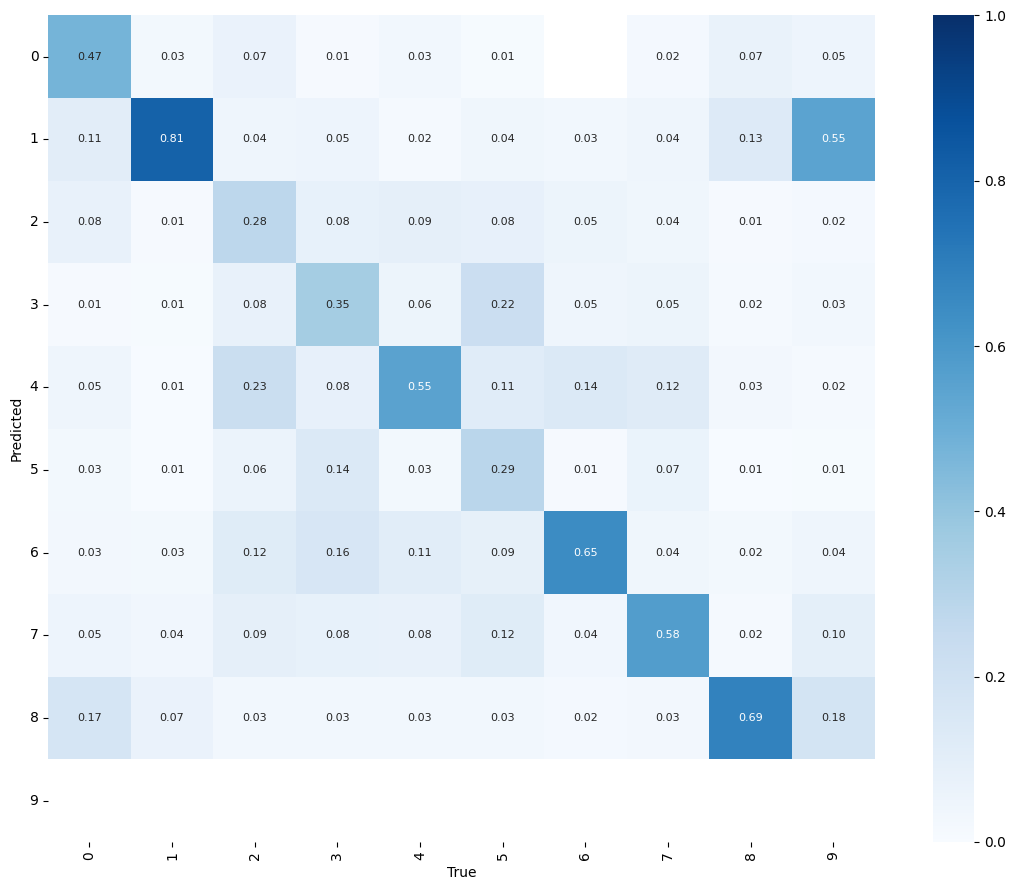

In [8]:
def plot_cm(cm, labels, save_path=None, normalize=False, on_plot=True):
    array = cm / (
        (cm.sum(0).reshape(1, -1) + 1e-9) if normalize else 1
    )  # normalize columns
    array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    ticklabels = labels
    vmax = 1.0 if normalize else None
    sns.heatmap(
        array,
        ax=ax,
        annot=True,
        annot_kws={"size": 8},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        vmax=vmax,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

    # title = "Confusion Matrix" + " Normalized" * normalize
    # ax.set_title(title)
    ax.set_xlabel("True")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Predicted")
    ax.set_yticklabels(labels, rotation=0)
    if save_path is not None:
        if normalize:
            save_path = save_path.replace(".png", "") + "_normalized.png"
        fig.savefig(save_path, dpi=250)
    if on_plot:
        plt.show()
    plt.close(fig)


labels_pred = np.array([r["label"] for r in results])
labels_gt = np.array([r["label_gt"] for r in results])
cm = confusion_matrix(labels_gt, labels_pred).T
# plot_cm(cm, np.arange(config.n_clusters), normalize=False)
plot_cm(cm, np.arange(config.n_clusters), normalize=True)

In [9]:
labels_prob = np.array([r["label_prob"] for r in results])
labels_prob[:5].astype(np.float16)

array([[4.8351e-04, 2.6169e-03, 1.5808e-02, 9.7412e-01, 1.7428e-04,
        2.4948e-03, 1.0910e-03, 9.4175e-04, 2.2964e-03, 0.0000e+00],
       [1.1959e-03, 9.8389e-01, 4.5800e-04, 1.3475e-03, 4.9067e-04,
        5.4312e-04, 4.2992e-03, 4.3774e-04, 7.3967e-03, 0.0000e+00],
       [2.8223e-01, 3.1738e-02, 6.1913e-03, 6.4354e-03, 1.4477e-03,
        6.0081e-03, 7.2365e-03, 2.2888e-03, 6.5625e-01, 0.0000e+00],
       [5.4346e-01, 1.4087e-01, 4.4975e-03, 6.2256e-03, 4.9553e-03,
        5.2643e-03, 1.5900e-02, 4.1695e-03, 2.7466e-01, 0.0000e+00],
       [1.5831e-04, 5.0020e-04, 2.0862e-04, 1.2565e-04, 9.9707e-01,
        2.5916e-04, 8.8549e-04, 1.1826e-04, 7.9632e-04, 0.0000e+00]],
      dtype=float16)

0


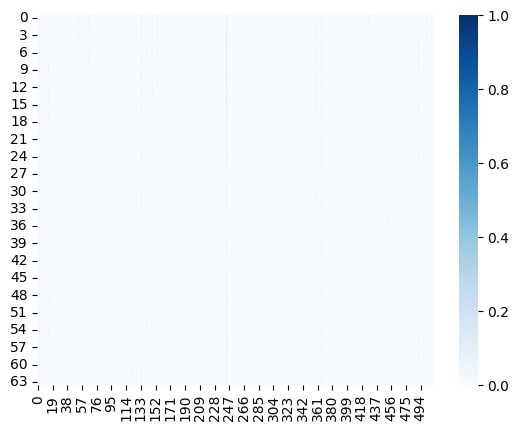

1


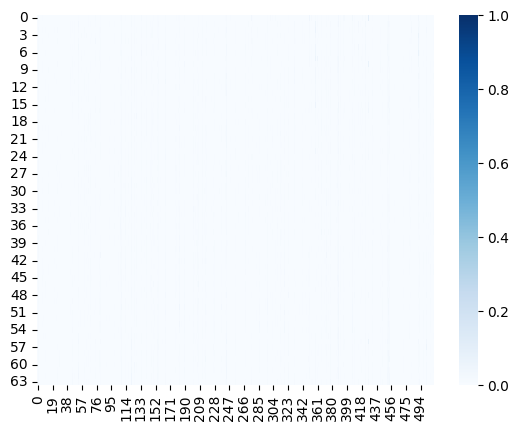

2


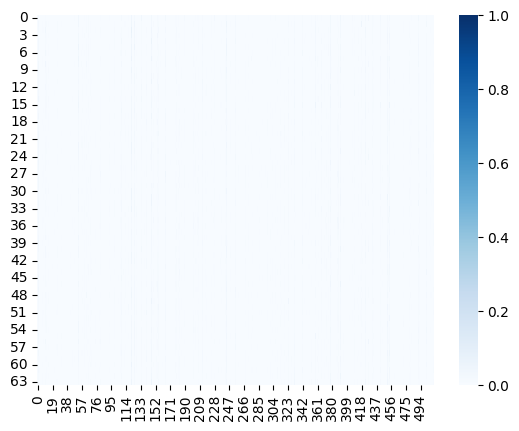

3


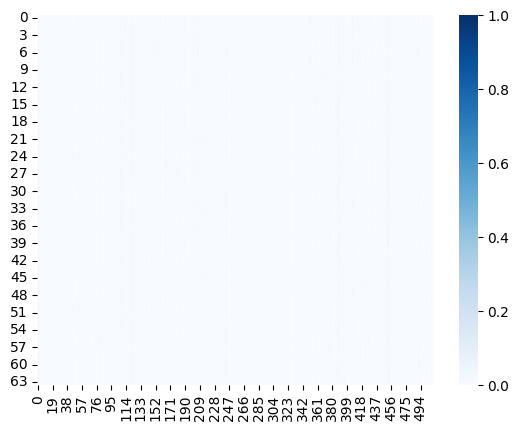

4


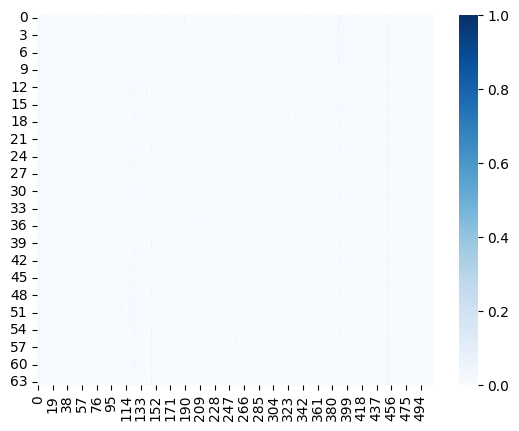

5


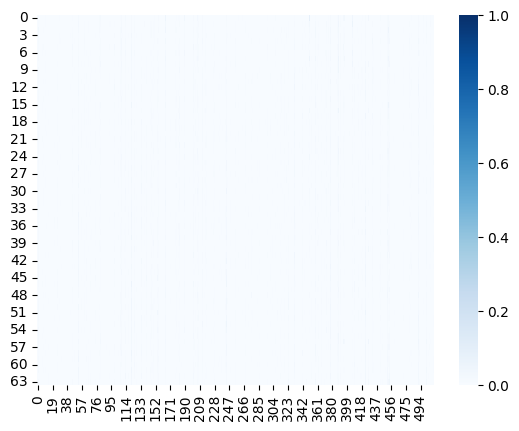

6


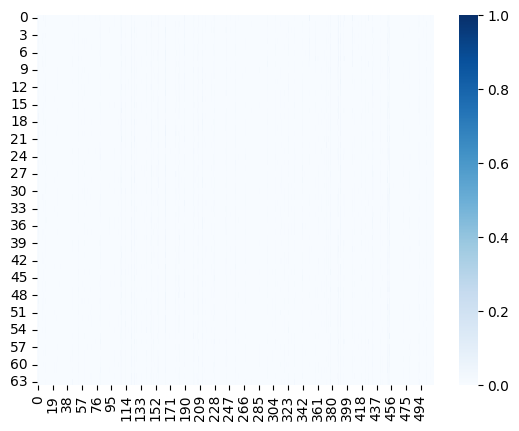

7


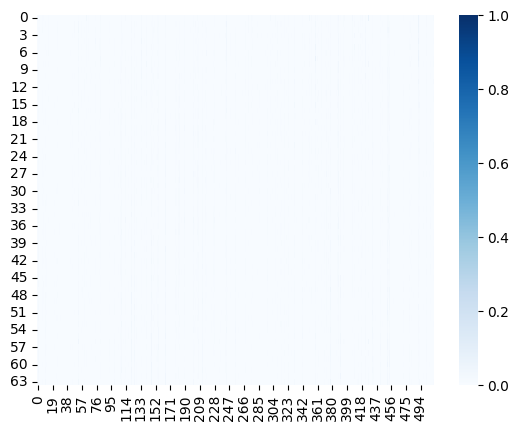

8


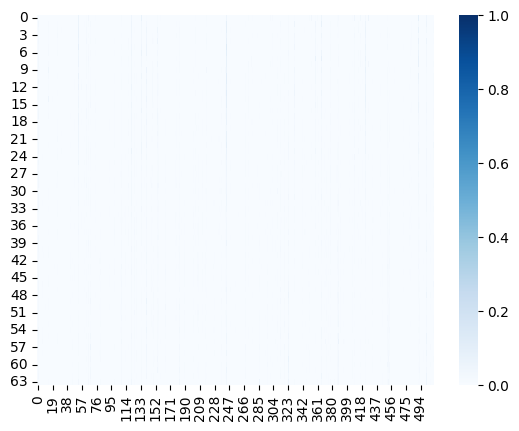

9


/tmp/ipykernel_1113397/526246665.py:17: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1).reshape(-1, 1)


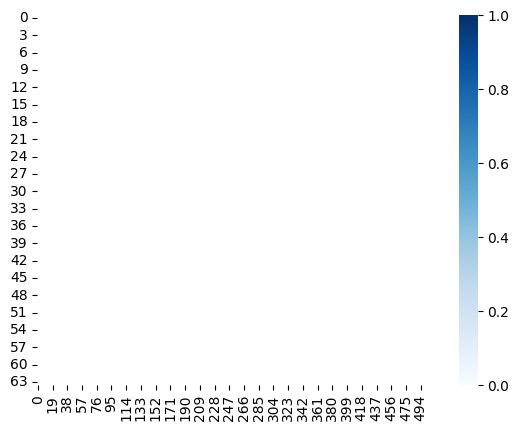

In [10]:
book_idxs = np.array([r["book_idx"] for r in results])
labels = np.array([r["label"] for r in results])

latent_idx_counts = {
    i: np.array(
        [[0 for k in range(config.book_size)] for j in range(latent_npts)]
    )  # zq (b, 7, 7)
    for i in range(config.n_clusters)
}
for label, book_idx in zip(labels, book_idxs):
    for j, k in enumerate(book_idx):
        latent_idx_counts[label][j, k] += 1

for label, counts in latent_idx_counts.items():
    print(label)
    cm = np.array(counts)
    cm = cm / cm.sum(axis=1).reshape(-1, 1)
    sns.heatmap(cm, cmap="Blues", vmax=1.0, vmin=0.0)
    plt.show()

100%|██████████| 999/999 [00:11<00:00, 88.65it/s]


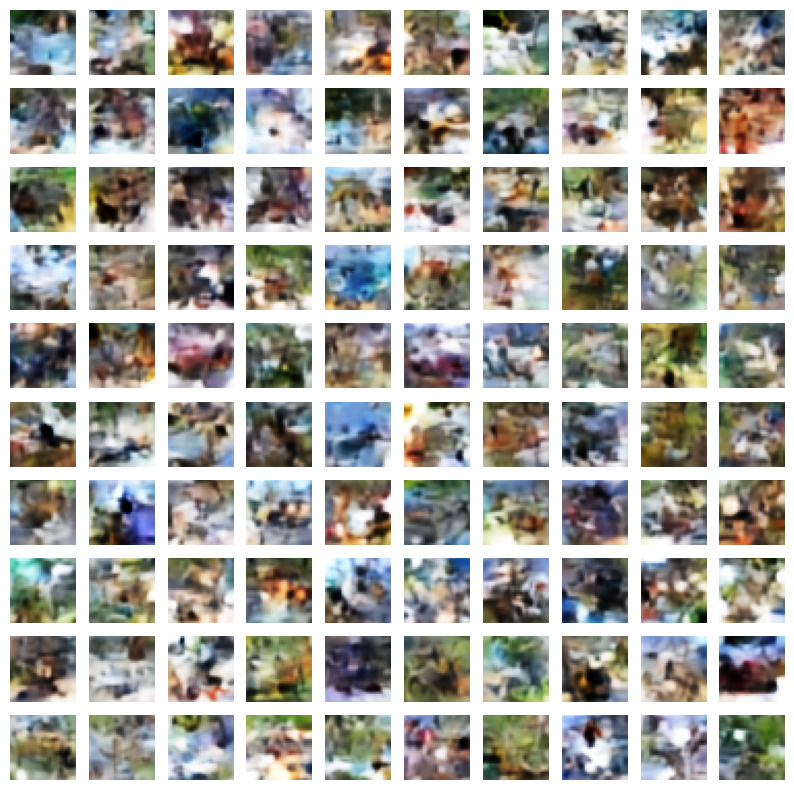

In [11]:
nsamples = 50
# generate images
c_probs = torch.empty(0, config.n_clusters)
result_gen = []
for i in range(config.n_clusters):
    c_probs_tmp = torch.eye(config.n_clusters)[i]
    c_probs_tmp = c_probs_tmp.unsqueeze(0).repeat(nsamples, 1)
    # c_probs = torch.cat([c_probs, c_probs_tmp], dim=0)
    result_gen += model.sample(c_probs_tmp)

imgs_gen = [r["gen_x"] for r in result_gen][::5]
plot_imgs(imgs_gen, nsamples // 5 * config.n_clusters)

In [12]:
from sklearn.manifold import TSNE


def plot_tsne(
    X,
    labels,
    classes,
    perplexity=10,
    figpath=None,
    is_show=True,
    cmap="tab20",
    lut=None,
    legend=True,
):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    embedded = tsne.fit_transform(X)
    unique_labels = np.unique(labels)
    cm = plt.get_cmap(cmap, lut)
    # plt.figure(figsize=(8, 8))
    for label in unique_labels:
        x = embedded[labels == label]
        if lut is not None:
            ci = np.where(unique_labels == label)[0].item()
        else:
            ci = int(label)
        c = cm(ci)
        plt.scatter(x.T[0], x.T[1], s=3, c=c, label=classes[label])

    if legend:
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    if figpath is not None:
        plt.savefig(figpath, bbox_inches="tight", dpi=300)
    if is_show:
        plt.show()
    plt.close()

/tmp/ipykernel_1113397/2562784764.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x.T[0], x.T[1], s=3, c=c, label=classes[label])


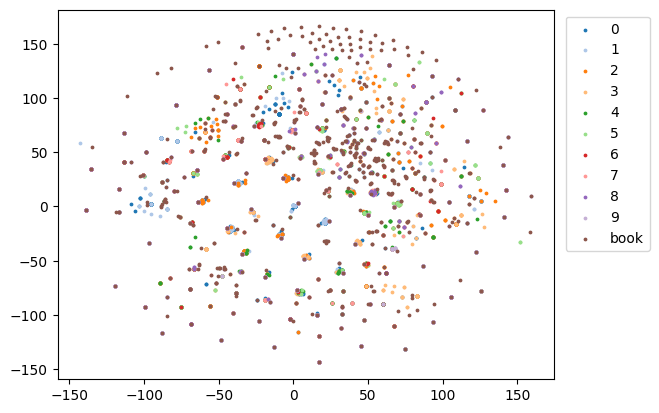

In [13]:
X = []
labels = []
for r in result_gen[::5]:
    X += r["zq"].reshape(-1, config.latent_dim).tolist()
    # X += r["z"].reshape(-1, config.latent_dim).tolist()
    labels += [int(r["gt"]) for _ in range(latent_npts)]

book = model.quantizer.book.detach().cpu().numpy()
X += book.reshape(config.book_size, config.latent_dim).tolist()
labels += [10 for _ in range(config.book_size)]

X = np.array(X)
labels = np.array(labels)
plot_tsne(X, labels, list(range(config.n_clusters)) + ["book"])

/tmp/ipykernel_1113397/2562784764.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x.T[0], x.T[1], s=3, c=c, label=classes[label])


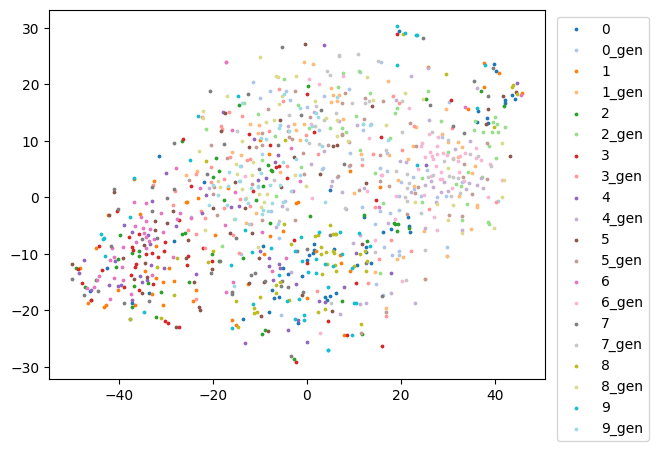

In [14]:
X = []
labels = []
for i in range(config.n_clusters):
    # X += [r["ze"].ravel() for r in results if r["label_gt"] == i][:100]
    X += [r["zq"].ravel() for r in results if r["label_gt"] == i][:50]
    labels += [2 * i for _ in range(50)]
    x_gen = [r["zq"].ravel() for r in result_gen if r["gt"] == i]
    X += x_gen
    labels += [2 * i + 1 for _ in range(len(x_gen))]

X = np.array(X)
labels = np.array(labels)
classes = []
for i in range(config.n_clusters):
    classes.append(i)
    classes.append(f"{i}_gen")
plot_tsne(X, labels, classes)